In [1]:
%matplotlib inline
import os
import sys
from os.path import dirname

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import pickle
import gdal
import georasters as gr
import multiprocessing as mp
import geopandas as gp
import matplotlib.gridspec as gridspec


def gamma_porp(a,b):
    from scipy import special
    return special.gamma(a)-special.gamma(a)*special.gammainc(a,b)


In [2]:
def intercept_rain(ppt, interception_depth):
    freq = ppt.index.freq
    idx = ppt.index.copy()
    prcp = ppt.copy()
    precip_pre = ppt.ppt.resample('D').mean()+1e-12
    precip_post = precip_pre.apply(lambda x: np.max([0,x-interception_depth])) 
    rng = pd.date_range(precip_post.index[0], precip_post.index[-1], freq=freq)
    daily_multiplication_factor = precip_post/precip_pre
    daily_multiplication_factor = pd.DataFrame({'factor':daily_multiplication_factor.resample(freq).ffill().tolist()},index=rng)
    ppt.ppt = daily_multiplication_factor.factor*prcp.ppt
    return ppt

def run_chunk(arguments):
    LAM, W0, alpha, dt, tw, pet, num_sims, cpu = arguments        
    t = np.linspace(0,tw,int(np.ceil(tw/dt)))
    CV = np.zeros_like(LAM)
    for i in range(np.shape(LAM)[0]):
        for j in range(np.shape(LAM)[1]):
            lam, w0 = LAM[i,j], W0[i,j]
            S = np.zeros((num_sims, len(t)))
            for num in range(num_sims): 
                rainfall = np.array([np.random.exponential(alpha) if np.random.uniform() > np.exp(-lam*dt) else 0.0 for i in range(len(t))])
                x = np.zeros_like(rainfall)
                for idx in range(len(rainfall)-1):
                    dx = rainfall[idx]/w0 - pet*x[idx]*dt/w0
                    x[idx+1] = x[idx] + dx
                    x[idx+1] = np.min([x[idx+1], 1])
                s = x*w0
                S[num,:] = s
            CV[i,j] = np.std(S[:,-1])/np.mean(S[:,-1])
    return (CV, cpu)

def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [8]:
rainfall = 10*pd.read_pickle('./data/elder_ppt.p') # it's stored in cm, convert mm
rainfall = intercept_rain(rainfall, 4.0)
wet_season = rainfall[(rainfall.index.month>=11)|(rainfall.index.month<=4)].ppt.ffill().values
lam = len(wet_season[wet_season>0])/float(len(wet_season))
alpha = np.mean(wet_season[wet_season>0])

runs = zero_runs(wet_season<=0)
lam_clustered = len(runs)/float(len(wet_season))
alpha_clustered = np.nanmean(np.array( [np.sum(wet_season[idx[0]:idx[1]]) for idx in runs]))

lam = lam_clustered
alpha = alpha_clustered
print('Rainfall frequency = %.3f per day, mean event depth = %.3f mm'%(lam, alpha))

Rainfall frequency = 0.124 per day, mean event depth = 61.985 mm


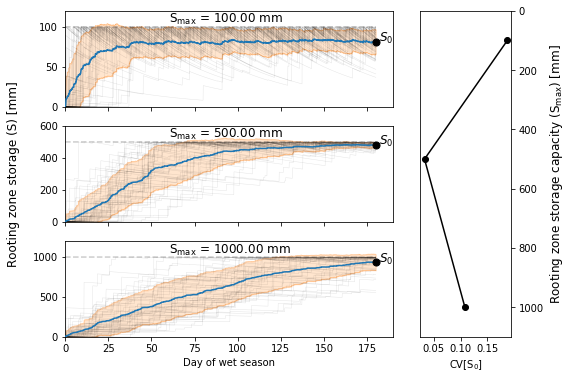

In [21]:
## try some wet season simulations against theory
tw = 180.0 # wet season length in days
pet = 2.0  # pet during wet season (mm/day)

W0 = [100, 500, 1000]
wet_seasons = []
CV = []
rainfall_totals = []
for w0 in W0:
    gam = w0/alpha
    k = pet_wet/w0
    dt = 0.1              
    t = np.linspace(0,tw,int(np.ceil(tw/dt)))

    # monte carlo simulations
    num_sims = 50
    S = np.zeros((num_sims, len(t)))
    for num in range(num_sims): 
        rainfall = np.array([np.random.exponential(alpha) if np.random.uniform() > np.exp(-lam*dt) else 0.0 for i in range(len(t))])
        x = np.zeros_like(rainfall)
        for i in range(len(rainfall)-1):
            dx = rainfall[i]/w0 - pet*x[i]*dt/w0
            x[i+1] = x[i] + dx
            x[i+1] = np.min([x[i+1], 1])
        s = x*w0
        S[num,:] = s
        rainfall_totals.append(np.sum(rainfall))
    wet_seasons.append(S)
    CV.append(np.std(S[:,-1])/np.mean(S[:,-1]))

fig = plt.figure(figsize=(8, 2*len(W0))) 
gs = gridspec.GridSpec(3, 4)
gs.update(wspace=0.3)
axs = [plt.subplot(gs[0, :3]), plt.subplot(gs[1, :3]), plt.subplot(gs[2, :3])]
ax_side = plt.subplot(gs[:, 3])

for i in range(len(axs)):
    X = wet_seasons[i]
    ax = axs[i]
    endS0 = np.mean(X,axis=0)[-1]
    ax.plot(t_coarse, np.mean(X,axis=0), label='Mean',zorder=10)
    std = np.std(X, axis=0)
    upper = np.mean(X,axis=0) + std
    lower = np.mean(X,axis=0) - std
    ax.plot(t, upper, c='C1', lw=0.5, alpha=0.5)
    ax.plot(t, lower, c='C1', lw=0.5, alpha=0.5)
    ax.fill_between(t, lower, upper, color='C1', alpha=0.2)
    ax.plot(t,np.transpose(X),'k',lw=0.5, alpha=0.1, label='MC sims')
    titlestr = '%.0f mm storage potential'%(W0[i])
    if ax==axs[-1]:
        ax.set_xlabel('Day of wet season')
    if ax!=axs[-1]:
        labs = ax.get_xticklabels()
        labs = ['' for i in range(len(labs))]
        ax.set_xticklabels(labs)
    w0max = np.ones_like(t)*W0[i]
    ax.plot(t_coarse, w0max, '--k', alpha=0.2)
    ax.annotate('S$_\mathrm{max}$ = %.2f mm'%(W0[i]), (1*tw/3,W0[i]*1.05), fontsize=12)
    ax.annotate('$S_{0}$'%(endS0), (tw+2,endS0), fontsize=12)
    ax.scatter(tw,endS0, c='k', s=50, zorder=100)
    ax.set_ylim([0,W0[i]+0.2*W0[i]])
    ax.set_xlim([0,tw+10])
    
ax_side.plot(CV,W0, '-ok')
ax_side.set_ylim([0,W0[-1]+100])
ax_side.invert_yaxis()
ax_side.xaxis.set_ticks_position('bottom')
ax_side.set_ylabel('Rooting zone storage capacity (S$_\mathrm{max}$) [mm]', fontsize=12)
ax_side.yaxis.set_ticks_position('right')
ax_side.yaxis.set_label_position('right')
ax_side.set_xlabel('CV[S$_0$]')
axs[1].set_ylabel('Rooting zone storage (S) [mm]\n', fontsize=12)
fig.savefig('./plots/goldilocks.pdf')

In [ ]:
# cores = mp.cpu_count()
# sys.stdout.write('There are %s cores'%(cores) + '\r\n')
# tw = 180.0 # wet season length in days
# pet = 2.0  # pet during wet season (mm/day)
# dt = 0.1
# alpha = 60.0
# num_sims = 1000
# W0 = np.linspace(50, 1000, 20)
# LAM = np.linspace(1/30., 8/30.0, 20)
# X,Y = np.meshgrid(LAM, W0)
# Xs, Ys = np.array_split(X,cores), np.array_split(Y, cores)
# args = [(Xs[i], Ys[i], alpha, dt, tw, pet, num_sims, range(cores)[i]) for i in range(len(Xs))]
# pool = mp.Pool()
# results = pool.map(run_chunk, args)
# CVS_list = [0 for i in range(len(Xs))]
# for result in results:
#      CVS_list[result[1]] = result[0]

# pool.close()
# pool.terminate()
# CVS = np.concatenate(CVS_list)
# plt.contourf(X,Y,CVS)
# plt.xlabel('Storm frequency [events per day]')
# plt.ylabel('Storage capacity [mm]')
# plt.title('Dry season storage sensitivity\nto climate and storage capacity')
# cb = plt.colorbar()
# cb.set_label('CV conditions @ dry season start ')

There are 4 cores
